In [45]:
import pickle
import matplotlib.pyplot as plt
import json
import networkx as nx
import pandas as pd
import numpy as np
from dwave.system import DWaveSampler, FixedEmbeddingComposite
import dwave.inspector

from plotters import plotHistogram, annotateSampleGraph, plotCSV, plotSampleGraph, plotArrangement
from qubo import createBQM
from sampleAnalysis import duplicates, findOverlaps, totalEntropy

identifier = "Haydn-3"
path = f"../Pickles/{identifier}/{identifier}_"

instruments = json.load(open(path + "instruments.json"))
phrases = pickle.load(open(path + "phrases.pkl", "rb"))
G = nx.read_graphml(path + "graph.graphml")
embedding = json.load(open(path + "embedding.json", "r"))
qa = FixedEmbeddingComposite(DWaveSampler(), embedding)

In [ ]:
reads = 3000

bqm = createBQM(G, phrases, instruments, 6, 6, 1)
sampleset = qa.sample(bqm, num_reads=reads, label=f"Haydn_{reads}")

In [ ]:
dwave.inspector.show(sampleset)
#print(sampleset.info["embedding_context"]["chain_strength"])
#print(sampleset.first.chain_break_fraction)
#plotSampleGraph(sampleset.first.sample, G, instruments)


In [ ]:
def recordChainStrength(strengthRange, bqm, filepath: str):
    
    file = pd.DataFrame()
    reads = 1000

    for s in strengthRange:
        sampleset = qa.sample(bqm, num_reads=reads, chain_strength=s, label=f"{identifier}_cs={s}")
        sample = sampleset.first

        A = annotateSampleGraph(sample.sample, G)

        new_row = pd.DataFrame({
            "Chain strength": [sampleset.info["embedding_context"]["chain_strength"]],
            "Total reads": [reads],
            "Time": [sampleset.info["timing"]["qpu_access_time"]],
            "Chain break fraction": [sample.chain_break_fraction],
            "Lowest energy": [bqm.energy(sample.sample)],
            "Total entropy": [totalEntropy(A)],
            "Overlaps": [findOverlaps(annotateSampleGraph(sample.sample, G))],
            "Duplicates": [len(duplicates(sample.sample, G))]
            })
    
        print(f"Chain strength {s} recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=False)


chainStrengths = range(12,42)
bqm = createBQM(G, phrases, instruments, 6, 6, 1)
recordChainStrength(chainStrengths, bqm, path+"chain-strength.csv")

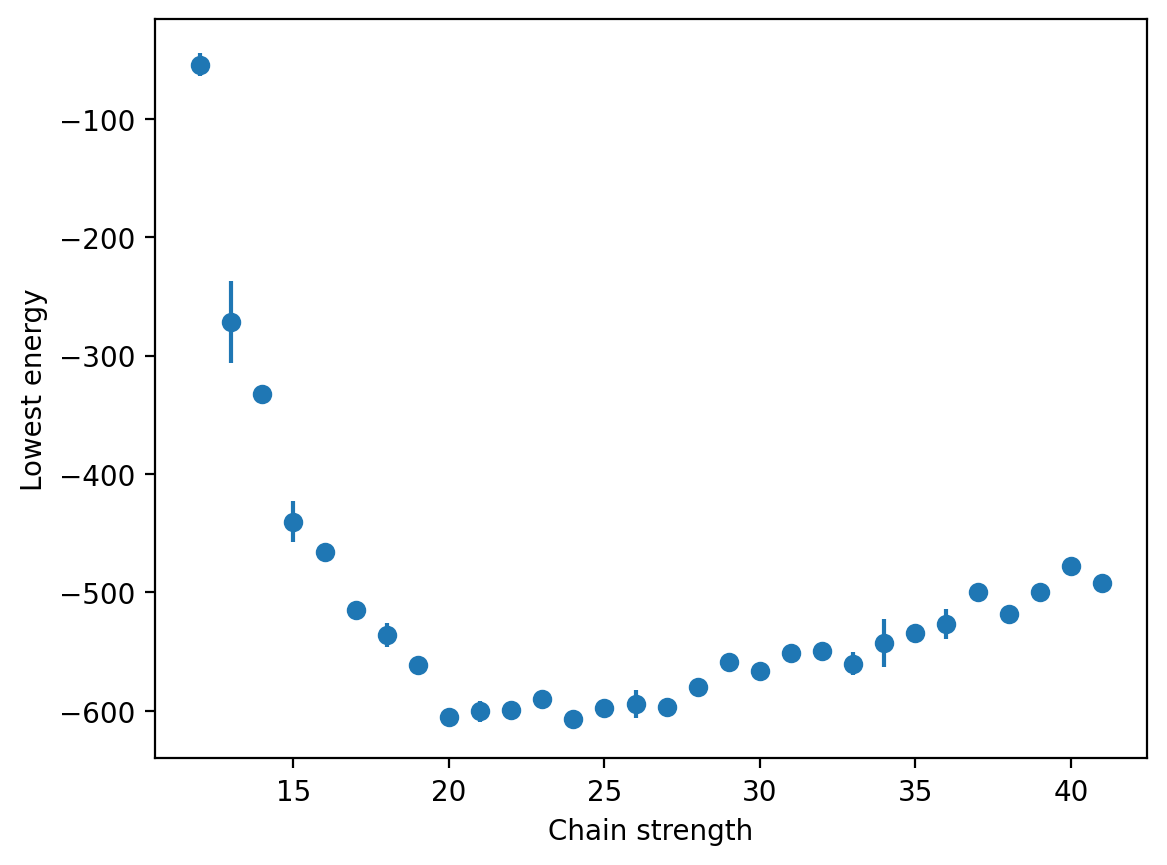

In [47]:
plotCSV(path+"chain-strength.csv", "Chain strength", "Lowest energy")
#plt.vlines(31.675,0,.1)

# ~25 optimal???
# chain_break_method=chain_breaks.discard?????